# Training and Testing


In [1]:
# set work dir if PyEPO is not installed
import os
os.chdir("../pkg")

In this tutorial, we will train and test end-to-end predict-then-optimize for different approaches.

## 1 Problem Example: Shortest Path

Consider a 5x5 grid network again. The figure shows that each node has top, bottom, left, and right neighbors. We aim to find the shortest path from left top to right bottom.

<img src="../images/shortestpath.png" width="500">

The weighted graph includes 25 nodes and 40 edges. The weights of the edges are the costs of the path. We load the synthetic dataset where the costs $\mathbf{c}$ are unknown and can be predicted from features $\mathbf{x}$.

``pyepo.data.shortestpath.genData`` allows us to generate data with various size, polynomial degree, and noise. We can learn more about the dataset [here](https://github.com/khalil-research/PyEPO/blob/main/notebooks/02%20Optimization%20Dataset.ipynb).

In [2]:
import pyepo
# generate data
grid = (5,5) # grid size
num_data = 1000 # number of training data
num_feat = 5 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.shortestpath.genData(num_data+1000, num_feat, grid, deg, e, seed=42)

Auto-Sklearn cannot be imported.


Thus, we can use ``optGrbModel`` to build a linear model with the Gurobi solver. For more details on ``optModel``, you can read tutorial [01 Optimization Model
](https://github.com/khalil-research/PyEPO/blob/main/notebooks/01%20Optimization%20Model.ipynb) and [documentation](https://khalil-research.github.io/PyEPO/build/html/content/examples/model.html).

In [3]:
# build optModel

import gurobipy as gp
from gurobipy import GRB
from pyepo.model.grb import optGrbModel

class shortestPathModel(optGrbModel):

    def __init__(self):
        self.grid = (5,5)
        self.arcs = self._getArcs()
        super().__init__()

    def _getArcs(self):
        """
        A helper method to get list of arcs for grid network

        Returns:
            list: arcs
        """
        arcs = []
        for i in range(self.grid[0]):
            # edges on rows
            for j in range(self.grid[1] - 1):
                v = i * self.grid[1] + j
                arcs.append((v, v + 1))
            # edges in columns
            if i == self.grid[0] - 1:
                continue
            for j in range(self.grid[1]):
                v = i * self.grid[1] + j
                arcs.append((v, v + self.grid[1]))
        return arcs

    def _getModel(self):
        """
        A method to build Gurobi model

        Returns:
            tuple: optimization model and variables
        """
        # ceate a model
        m = gp.Model("shortest path")
        # varibles
        x = m.addVars(self.arcs, name="x")
        # sense
        m.modelSense = GRB.MINIMIZE
        # flow conservation constraints
        for i in range(self.grid[0]):
            for j in range(self.grid[1]):
                v = i * self.grid[1] + j
                expr = 0
                for e in self.arcs:
                    # flow in
                    if v == e[1]:
                        expr += x[e]
                    # flow out
                    elif v == e[0]:
                        expr -= x[e]
                # source
                if i == 0 and j == 0:
                    m.addConstr(expr == -1)
                # sink
                elif i == self.grid[0] - 1 and j == self.grid[0] - 1:
                    m.addConstr(expr == 1)
                # transition
                else:
                    m.addConstr(expr == 0)
        return m, x

In [4]:
optmodel = shortestPathModel()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-29


## 2 Dataset and Data Loader

PyTorch provides two data primitives: ``Dataset`` and ``DataLoader``, which allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples. The PyEPO module ``optDataset`` stores features $\mathbf{x}$ and costs $\mathbf{c}$, then computes the corresponding optimal solutions $\mathbf{w}^*$ and objective values $\mathbf{z}^*$.

More details on ``optDataset`` is [here](https://github.com/khalil-research/PyEPO/blob/main/notebooks/02%20Optimization%20Dataset.ipynb).

In [5]:
# split train test data
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)

In [6]:
# get optDataset
dataset_train = pyepo.data.dataset.optDataset(optmodel, x_train, c_train)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, c_test)

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:01<00:00, 755.64it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:01<00:00, 788.41it/s]


In [7]:
# set data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## 3 Linear Regression on PyTorch

PyTorch is an open-source machine learning library primarily used for developing and training deep learning models such as neural networks. It is developed by Facebook's AI Research lab and is based on the Torch library. PyTorch provides a flexible and intuitive interface for creating and training models.

In PyTorch, the ``nn.Module`` is a base class for all neural network modules in the library. It provides a convenient way to organize the layers of a model, and to define the forward pass of the model.

Here, we build the simplest PyTorch model, linear regression.

In [8]:
from torch import nn

# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, (grid[0]-1)*grid[1]+(grid[1]-1)*grid[0])
    
    def forward(self, x):
        out = self.linear(x)
        return out

Then, we can initialize the predictor.

In [9]:
import torch
# init model
reg = LinearRegression()

## 4 Training and Testing

The core capability of PyEPO is to build optimization models with GurobiPy, Pyomo, or any other solvers and algorithms, then embed the optimization model into an artificial neural network for the end-to-end training. For this purpose, PyEPO implements **SPO+ loss** and **differentiable Black-Box optimizer**, **differentiable perturbed optimizer**, and **Fenchel-Young loss with Perturbation** as PyTorch autograd modules.

We will train and test the above aproaches.

### Introduction to Metrics

``pyepo.metric.regret`` is to evaluate model performance. Regret (also called SPO loss) $l_{Regret}(\hat{\mathbf{c}}, \mathbf{c}) = \mathbf{c}^T \mathbf{w}^*_{\hat{\mathbf{c}}} - z^*_{\mathbf{c}}$ aims to measure the error in decision-making. It evaluates the distance between the objective value of the solution from predicted cost $\hat{\mathbf{c}}$ and the true optimal objective value $z^*_{c}$.

To calculate regret, ``pyepo.metric.regret`` requires:
- ``predmodel``: a regression neural network for cost prediction
- ``optmodel``: an PyEPO optimization model
- ``dataloader``: PyTorch dataloader from optDataset to evaluate

The following code block is an example:

In [10]:
import pyepo
regret = pyepo.metric.regret(reg, optmodel, loader_test)

### 4.2 Smart Predict-then-Optimize Loss+

Elmachtoub, A. N., & Grigas, P. (2022). Smart “predict, then optimize”. Management Science, 68(1), 9-26.

SPO+ Loss is a surrogate loss function of SPO Loss (Regret), which measures the decision error of optimization problem. For SPO/SPO+ Loss, the objective function is linear and constraints are known and fixed, but the cost vector need to be predicted from contextual data. The SPO+ Loss is convex with non-zero subgradient. Thus, allows us to design an algorithm based on stochastic gradient descent.

First of all, we initialize the predictor.

In [ ]:
import torch
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

# set adam optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

``pyepo.func.SPOPlus`` allows us to set a SPO+ loss for training, which requires parameters:
- ``optmodel``: an PyEPO optimization model
- ``processes``: number of processors for multi-thread, 1 for single-core, 0 for all of cores

In [ ]:
# init SPO+ loss
spop = pyepo.func.SPOPlus(optmodel, processes=1)

#### Training

Then, we can train a linear predictor with SPO+ loss to predict unknown cost coefficients and make decisions.

To compute SPO+ loss, ``spop`` requires $\mathbf{\hat{c}}$, $\mathbf{c}$, $\mathbf{w}^*_{\mathbf{c}}$, and $\mathbf{z}^*_{\mathbf{c}}$.

In [ ]:
# train model
num_epochs = 20
reg.train()
# init log
loss_log = []
loss_log_regret = [pyepo.metric.regret(reg, optmodel, loader_test)]
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = spop(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # log
        loss_log.append(loss.item())
    regret = pyepo.metric.regret(reg, optmodel, loader_test)
    loss_log_regret.append(regret)
    print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%".format(epoch+1, loss.item(), regret*100))

#### Learning Curve on Training Set

In [ ]:
from matplotlib import pyplot as plt
# draw plot for training loss
plt.figure(figsize=(8, 4))
plt.plot(loss_log, color="c", lw=1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Iters", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.title("Learning Curve on Training Set", fontsize=16)
plt.show()

#### Learning Curve on Test Set

In [ ]:
# draw plot for regret on test
fig = plt.figure(figsize=(8, 4))
plt.plot(range(num_epochs+1), loss_log_regret, color="royalblue", ls="--", alpha=0.7, lw=1)
plt.xticks(range(0, num_epochs+1, 2), fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Regret", fontsize=16)
plt.title("Learning Curve on Test Set", fontsize=16)
plt.show()

### 4.3 Perturbed Fenchel-Young Loss

Berthet, Q., Blondel, M., Teboul, O., Cuturi, M., Vert, J. P., & Bach, F. (2020). Learning with differentiable pertubed optimizers. Advances in neural information processing systems, 33, 9508-9519.

Perturbed Fenchel-Young loss (PYFL) uses perturbation techniques with Monte-Carlo samples. The use of the loss improves the algorithmic by the specific expression of the gradients of the loss. For the perturbed optimizer, the cost vector need to be predicted from contextual data and are perturbed with Gaussian noise. The Fenchel-Young loss allows to directly optimize a loss between the features and solutions with less computation. Thus, allows us to design an algorithm based on stochastic gradient descent.

First of all, we initialize the predictor.

In [ ]:
import torch
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

# set adam optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

``pyepo.func.perturbedFenchelYoung`` allows us to set a Fenchel-Young loss for training, which requires parameters:
- ``optmodel``: a PyEPO optimization model
- ``n_samples``: number of Monte-Carlo samples
- ``sigma``:  the amplitude of the perturbation for costs
- ``processes``: number of processors for multi-thread, 1 for single-core, 0 for all of the cores
- ``seed``: random state seed for perturbations

In [ ]:
# init pfyl loss
fyloss = pyepo.func.perturbedFenchelYoung(optmodel, n_samples=1, sigma=1.0, processes=1)

#### Training

Then, we can train a linear predictor with Fenchel-Young loss to predict unknown cost coefficients and make decisions.

To compute Fenchel-Young loss, ``fyloss`` requires $\mathbf{\hat{c}}$ and $\mathbf{w}^*_{\mathbf{c}}$.

In [ ]:
# train model
num_epochs = 20
reg.train()
# init log
loss_log = []
loss_log_regret = [pyepo.metric.regret(reg, optmodel, loader_test)]
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # linear regression
        cp = reg(x)
        # loss
        loss = fyloss(cp, w).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    regret = pyepo.metric.regret(reg, optmodel, loader_test)
    loss_log_regret.append(regret)
    print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%".format(epoch+1, loss.item(), regret*100))

#### Learning Curve on Training Set

In [ ]:
from matplotlib import pyplot as plt
# draw plot for training loss
plt.figure(figsize=(8, 4))
plt.plot(loss_log, color="c", lw=1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Iters", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.title("Learning Curve on Training Set", fontsize=16)
plt.show()

#### Learning Curve on Test Set

In [ ]:
# draw plot for regret on test
fig = plt.figure(figsize=(8, 4))
plt.plot(range(num_epochs+1), loss_log_regret, color="royalblue", ls="--", alpha=0.7, lw=1)
plt.xticks(range(0, num_epochs+1, 2), fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Regret", fontsize=16)
plt.title("Learning Curve on Test Set", fontsize=16)
plt.show()

### 4.4 Differentiable Black-Box Optimizer

Pogančić, M. V., Paulus, A., Musil, V., Martius, G., & Rolinek, M. (2020). Differentiation of blackbox combinatorial solvers. In International Conference on Learning Representations.

Differentiable black-box optimizer estimates gradients from interpolation, replacing the zero gradients. For differentiable block-box, the objective function is linear and constraints are known and fixed, but the cost vector need to be predicted from contextual data.

First of all, we initialize the predictor

In [ ]:
import torch
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

# set adam optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

``pyepo.func.blackboxOpt`` allows us to set a differentiable solver, which requires parameters:
- ``optmodel``: a PyEPO optimization model
- ``lambd``: a parameter to contral interpolation degree
- ``processes``: number of processors for multi-thread, 1 for single-core, 0 for all of the cores

In [ ]:
# init dbb solver
dbb = pyepo.func.blackboxOpt(optmodel, lambd=20, processes=1) 

Unlike SPO+ and PFYL, DBB is not a loss function so we need to define a loss.

In [ ]:
# set loss
criterion = nn.L1Loss()

#### Training

In [ ]:
# train model
num_epochs = 20
reg.train()
# init log
loss_log = []
loss_log_regret = [pyepo.metric.regret(reg, optmodel, loader_test)]
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # linear regression
        cp = reg(x)
        # black-box optimizer
        wp = dbb(cp)
        # objective value
        zp = (wp * c).sum(1).view(-1, 1)
        # loss
        loss = criterion(zp, z)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    regret = pyepo.metric.regret(reg, optmodel, loader_test)
    loss_log_regret.append(regret)
    print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%".format(epoch+1, loss.item(), regret*100))

#### Learning Curve on Training Set

In [ ]:
from matplotlib import pyplot as plt
# draw plot for training loss
plt.figure(figsize=(8, 4))
plt.plot(loss_log, color="c", lw=1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Iters", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.title("Learning Curve on Training Set", fontsize=16)
plt.show()

#### Learning Curve on Test Set

In [ ]:
# draw plot for regret on test
fig = plt.figure(figsize=(8, 4))
plt.plot(range(num_epochs+1), loss_log_regret, color="royalblue", ls="--", alpha=0.7, lw=1)
plt.xticks(range(0, num_epochs+1, 2), fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Regret", fontsize=16)
plt.title("Learning Curve on Test Set", fontsize=16)
plt.show()

### 4.5 Differentiable Perturbed Optimizer

Berthet, Q., Blondel, M., Teboul, O., Cuturi, M., Vert, J. P., & Bach, F. (2020). Learning with differentiable pertubed optimizers. Advances in neural information processing systems, 33, 9508-9519.

Differentiable perturbed optimizer uses Monte-Carlo samples to estimate solutions, in which randomly perturbed costs are sampled to optimize. For the perturbed optimizer, the cost vector needs to be predicted from contextual data and are perturbed with Gaussian noise. The perturbed optimizer is differentiable in its inputs with non-zero Jacobian, thus allowing us to design an algorithm based on stochastic gradient descent.

First of all, we initialize the predictor.

In [ ]:
import torch
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

# set adam optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

``pyepo.func.perturbedOpt`` allows us to set a SPO+ loss for training, which requires parameters:
- ``optmodel``: a PyEPO optimization model
- ``n_samples``: number of Monte-Carlo samples
- ``sigma``:  the amplitude of the perturbation for costs
- ``processes``: number of processors for multi-thread, 1 for single-core, 0 for all of the cores
- ``seed``: random state seed for perturbations

In [ ]:
# init ptb solver
ptb = pyepo.func.perturbedOpt(optmodel, n_samples=10, sigma=1.0, processes=1)

#### Training

In [ ]:
# train model
num_epochs = 20
reg.train()
# init log
loss_log = []
loss_log_regret = [pyepo.metric.regret(reg, optmodel, loader_test)]
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # linear regression
        cp = reg(x)
        # perturbed optimizer
        we = ptb(cp)
        # loss
        loss = criterion(we, w)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    regret = pyepo.metric.regret(reg, optmodel, loader_test)
    loss_log_regret.append(regret)
    print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%".format(epoch+1, loss.item(), regret*100))

#### Learning Curve on Training Set

In [ ]:
from matplotlib import pyplot as plt
# draw plot for training loss
plt.figure(figsize=(8, 4))
plt.plot(loss_log, color="c", lw=1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Iters", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.title("Learning Curve on Training Set", fontsize=16)
plt.show()

#### Learning Curve on Test Set

In [ ]:
# draw plot for regret on test
fig = plt.figure(figsize=(8, 4))
plt.plot(range(num_epochs+1), loss_log_regret, color="royalblue", ls="--", alpha=0.7, lw=1)
plt.xticks(range(0, num_epochs+1, 2), fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Regret", fontsize=16)
plt.title("Learning Curve on Test Set", fontsize=16)
plt.show()

### 4.6 Noise Contrastive Estimation

Mulamba, M., Mandi, J., Diligenti, M., Lombardi, M., Lopez, V. B., & Guns, T. (2021, August). Contrastive Losses and Solution Caching for Predict-and-Optimize. In 30th International Joint Conference on Artificial Intelligence (IJCAI-21)

The NCE loss measures the disparity in the objective values between the true solution and a pool of feasible non-optimal solutions.

In [17]:
import torch
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

# set adam optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

``pyepo.func.ListwiseLTR`` allows us to use a listwise learning to rank loss for training, which requires parameters:
- ``optmodel``: an PyEPO optimization model
- ``processes``: number of processors for multi-thread, 1 for single-core, 0 for all of cores
- ``solve-ratio``: a ratio between 0 and 1 that denotes for what proportion of cost vectors predicted during training the instantiated optimization problem should be solved. Whenever the optimization problem is solved, the obtained solution is added to the solution pool which is ranked over.
- ``dataset``: a dataset to initialize the solution pool with. Usually this is simply the training set.

In [18]:
nce = pyepo.func.NCE_MAP(optmodel, processes=1, solve_ratio=0.05, dataset=dataset_train)

Num of cores: 1


#### Training

In [ ]:
# train model
num_epochs = 20
reg.train()
# init log
loss_log = []
loss_log_regret = [pyepo.metric.regret(reg, optmodel, loader_test)]
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        # loss
        loss = nce(cp, c, w)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    regret = pyepo.metric.regret(reg, optmodel, loader_test)
    loss_log_regret.append(regret)
    print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%".format(epoch+1, loss.item(), regret*100))

#### Learning Curve on Training Set

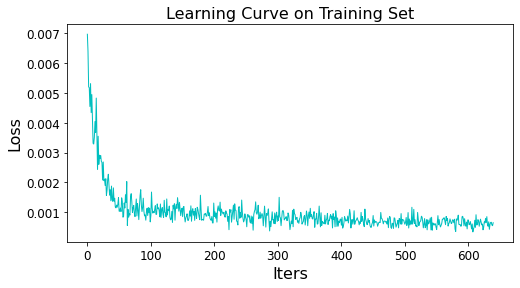

In [15]:
from matplotlib import pyplot as plt
# draw plot for training loss
plt.figure(figsize=(8, 4))
plt.plot(loss_log, color="c", lw=1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Iters", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.title("Learning Curve on Training Set", fontsize=16)
plt.show()

#### Learning Curve on Test Set

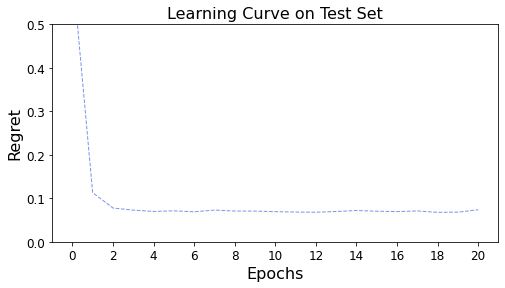

In [16]:
# draw plot for regret on test
fig = plt.figure(figsize=(8, 4))
plt.plot(range(num_epochs+1), loss_log_regret, color="royalblue", ls="--", alpha=0.7, lw=1)
plt.xticks(range(0, num_epochs+1, 2), fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Regret", fontsize=16)
plt.title("Learning Curve on Test Set", fontsize=16)
plt.show()

### 4.7 Listwise Learning To Rank

Mandi, J., Bucarey, V., Mulamba, M., & Guns, T. (2022). Decision-focused learning: through the lens of learning to rank. Proceedings of the 39th International Conference on Machine Learning.

The listwise learning to rank loss measures the difference in how the predicted cost vector and the true cost vector rank a pool of feasible solutions.

First of all, we initialize the predictor

In [11]:
import torch
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

# set adam optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

``pyepo.func.ListwiseLTR`` allows us to use a listwise learning to rank loss for training, which requires parameters:
- ``optmodel``: an PyEPO optimization model
- ``processes``: number of processors for multi-thread, 1 for single-core, 0 for all of cores
- ``solve-ratio``: a ratio between 0 and 1 that denotes for what proportion of cost vectors predicted during training the instantiated optimization problem should be solved. Whenever the optimization problem is solved, the obtained solution is added to the solution pool which is ranked over.
- ``dataset``: a dataset to initialize the solution pool with. Usually this is simply the training set.

In [12]:
listwise_ltr = pyepo.func.ListwiseLTR(optmodel, processes=1, solve_ratio=0.05, dataset=dataset_train)

Num of cores: 1


#### Training

In [13]:
# train model
num_epochs = 20
reg.train()
# init log
loss_log = []
loss_log_regret = [pyepo.metric.regret(reg, optmodel, loader_test)]
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        # loss
        loss = listwise_ltr(cp, c)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    regret = pyepo.metric.regret(reg, optmodel, loader_test)
    loss_log_regret.append(regret)
    print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%".format(epoch+1, loss.item(), regret*100))

Epoch   1, Loss:   0.0060, Regret: 13.6305%
Epoch   2, Loss:   0.0060, Regret:  8.3435%
Epoch   3, Loss:   0.0053, Regret:  7.7715%
Epoch   4, Loss:   0.0055, Regret:  7.5873%
Epoch   5, Loss:   0.0050, Regret:  8.6055%
Epoch   6, Loss:   0.0051, Regret:  7.9227%
Epoch   7, Loss:   0.0052, Regret:  7.2338%
Epoch   8, Loss:   0.0047, Regret:  7.8171%
Epoch   9, Loss:   0.0048, Regret:  7.6403%
Epoch  10, Loss:   0.0047, Regret:  7.6796%
Epoch  11, Loss:   0.0045, Regret:  8.2836%
Epoch  12, Loss:   0.0046, Regret:  7.9703%
Epoch  13, Loss:   0.0043, Regret:  7.6323%
Epoch  14, Loss:   0.0043, Regret:  7.6712%
Epoch  15, Loss:   0.0041, Regret:  7.5853%
Epoch  16, Loss:   0.0041, Regret:  8.1565%
Epoch  17, Loss:   0.0041, Regret:  8.0111%
Epoch  18, Loss:   0.0039, Regret:  7.6767%
Epoch  19, Loss:   0.0037, Regret:  8.1947%
Epoch  20, Loss:   0.0037, Regret:  7.3645%


#### Learning Curve on Training Set

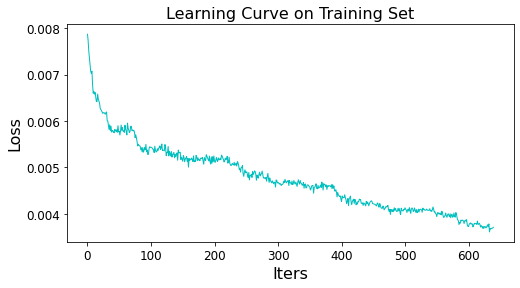

In [15]:
from matplotlib import pyplot as plt
# draw plot for training loss
plt.figure(figsize=(8, 4))
plt.plot(loss_log, color="c", lw=1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Iters", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.title("Learning Curve on Training Set", fontsize=16)
plt.show()

#### Learning Curve on Test Set

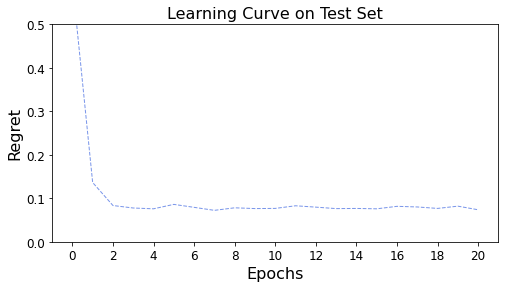

In [16]:
# draw plot for regret on test
fig = plt.figure(figsize=(8, 4))
plt.plot(range(num_epochs+1), loss_log_regret, color="royalblue", ls="--", alpha=0.7, lw=1)
plt.xticks(range(0, num_epochs+1, 2), fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 0.5)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Regret", fontsize=16)
plt.title("Learning Curve on Test Set", fontsize=16)
plt.show()